# Classifier visualisation

In [48]:
#
# imports
#
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt 
import scipy.misc
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, merge, GlobalAveragePooling2D
from keras.layers.merge import Add, Multiply, Average, Maximum, Concatenate, Dot
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model
import  keras.utils

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print(kv)
print(sv)
print(mv)
print(nv)

2.1.2
0.19.1
2.1.0
1.13.3


In [49]:
#
# setup paths
#
top_dir = "/home/mike/git//sar_classify_investigation/resources"

model_dir = top_dir + "/model_v1.0"
crops_dir = top_dir  + "/crops"   # chinese turbine crops
shapefile_dir = top_dir + "/results_shapefile"
training_crops_dir = top_dir + "/training/50x50/turbine" 

In [50]:
#
# load models
#
cnn_50x50 = load_model(os.path.join(model_dir, "fcn_50x50_v1.h5"))


In [51]:
#
# load results shapefile
#
results_df = gpd.read_file(os.path.join(shapefile_dir, "S1A_IW_GRDH_1SDV_20170924T100355_20170924T100420_018516_01F333_9052_withactual.shp"))


In [52]:
cnn_50x50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 50, 50, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 25, 25, 32)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 25, 25, 64)   18496       max_pooling2d_13[0][0]           
__________________________________________________________________________________________________
max_poolin

In [53]:
# 
# load Chinese 50x50 crops
#
list_of_50x50_crops = []
crop_save_dir_50x50 = os.path.join(crops_dir, '50x50')

list_of_distance_to_land_features = []

for idx, row in results_df.iterrows():
    list_of_distance_to_land_features.append(row['distance'])
    file_path = os.path.join(crop_save_dir_50x50, row['image_id'] + '_' + str(row['blob_id']) + '.png')

    image = scipy.misc.imread(file_path, 0)
    if image is not None:
        list_of_50x50_crops.append(image)
    else:
        print("Cannot open file: " + file_path)


array_of_50x50_crops = np.asarray(list_of_50x50_crops)
array_of_50x50_crops_disp = array_of_50x50_crops
array_of_distance_to_land_features = np.asarray(list_of_distance_to_land_features)
array_of_distance_to_land_features = np.expand_dims(array_of_distance_to_land_features, axis=1)
array_of_50x50_crops = np.expand_dims(array_of_50x50_crops, axis=3)

In [54]:
cnn_50x50.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
predictions = cnn_50x50.predict([array_of_50x50_crops, array_of_distance_to_land_features], batch_size=32, verbose=1)
preds = predictions[:, [0, 1, 2]].tolist()

166/166 [==============================] - 0s 3ms/step


In [83]:
print(predictions.shape)


(166, 3)


------------------ Crop: 100 ------------------
Oil: 0.0
Turbine: 0.0
Other: 1.0


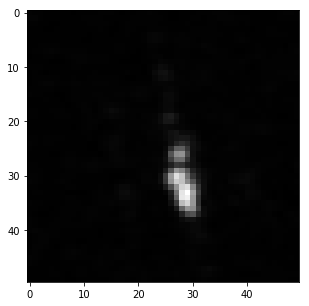

Conv Layer 1
Conv Layer 3
Conv Layer 5
Conv Layer 7
Conv Layer 10
Conv Layer 14


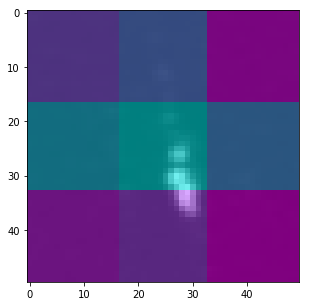

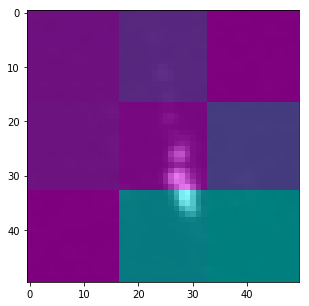

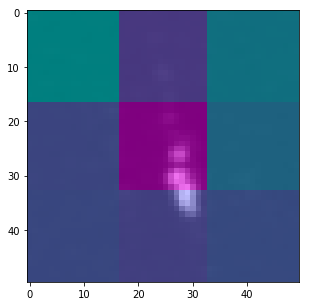

In [164]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

x = 100 #crop of interest
models_conv_layers = [19, 17, 15, 13, 10, 6]
l = cnn_50x50.layers                                                

def get_cm(inp, label):
    conv = conv_fn([inp,0])[0][0,:,:,label]
#     print(conv.shape)
#     print(conv)
    new_array =  scipy.misc.imresize(conv, (50,50), interp='nearest')
#     print(new_array)
    return new_array

print("------------------ Crop: " + str(x) + " ------------------")
print("Oil: " + str(round(predictions[0][0],2)))
print("Turbine: " + str(round(predictions[0][1],2)))
print("Other: " + str(round(predictions[0][2],2)))
plt.imshow(array_of_50x50_crops_disp[x], cmap='Greys_r')
plt.show()
classes = ['Oil', 'Turbine', 'Other']
input1 = np.expand_dims(array_of_50x50_crops[x], 0)
input2 = np.expand_dims(array_of_distance_to_land_features[x], 0)
for n in models_conv_layers:
    print("Conv Layer " + str(20 - n))
    conv_fn = K.function([l[0].input, K.learning_phase()], [l[-n].output])
    if n == 6:
        for n in range(0, 3):
#            print(classes[n])
            cm = get_cm(input1, n)
#             for t in range(0, 50):
#                 print(np.min(cm[t]), np.max(cm[t]))
            plt.figure(figsize=(10,5))
            plt.imshow(np.squeeze(array_of_50x50_crops_disp[x]), cmap='Greys_r')
            plt.imshow(cm, cmap="cool", alpha=0.5)
            plt.show()
#     if n == 19:
#         for n in range(0, 32):
#             cm = get_cm(input1, n)
#             print(str(n))
#             plt.figure(figsize=(10,5))
#             plt.imshow(np.squeeze(array_of_50x50_crops_disp[x]), cmap='Greys_r')
#             plt.imshow(cm, cmap="cool", alpha=0.5)
#             plt.show()
            

    # Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, 
#     CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
#     PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r,
#     PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, 
#     RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, 
#     Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, 
#     YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, 
#     bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, 
#     gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, 
#     gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, 
#     hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, 
#     pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, 
#     spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, 
#     terrain_r, viridis, viridis_r, winter, winter_r